

# Coursework 2 - Loan Default Probability 

The goal of this case study is to build a machine learning model to predict the probability that a loan will default. By the end of the analysis you should be able to recommend a choice of model and associated hyperparameters.

The comment is a guide for you but is not strict - you can use more cells or less. If you want to try other things then you can but it is not gauranteed to raise your score. What I want you to do is to do the things I ask for well and to explain them clearly. 

### Authors:
@ Puen YUAN  
@ Runze CAI  
@ Hui ZENG 

In [206]:
# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

## Overview

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Data Preparation and Feature Selection](#2)
    * [3.1. Preparing the predicted variable](#2.1)    
    * [3.2. Feature Selection-Limit the Feature Space](#2.2)
        * [3.2.1.  Features elimination by significant missing values ](#2.2.1)
        * [3.2.2.  Features elimination based on the intutiveness](#2.2.2)
        * [3.2.3.  Features elimination based on the correlation](#2.2.3)   
* [4. Feature Engineering and Exploratory Analysis](#3)
    * [4.1 Feature Analysis and Exploration](#3.1)
        * [4.1.1. Analysing the categorical features](#3.1.1)
        * [4.1.2  Analysing the continuous features ](#3.1.2) 
    * [4.2.Encoding Categorical Data](#3.2)
    * [4.3.Sampling Data](#3.3)    
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
    * [7.3. Save model for later use](#6.3)


<a id='0'></a>
# 1. Problem Definition

This case study aims to analyze data for loans through 2007-2017Q3 from Lending Club available on Kaggle. Dataset contains over 887 thousand observations and 150 variables among which one is describing the loan status. The predicted variable is “Charge-Off ”. A charge-off is a debt that a creditor has given up trying to collect on after you’ve missed payments for several months. You want a model that can predict charge-off.

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

## 2.1. Load all the python packages 

In [207]:
# DO THIS HERE
import numpy as np     
import pandas as pd     
import matplotlib.pyplot as plt     
%matplotlib inline
import matplotlib as mpl    
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,cross_val_score,GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE

<a id='1.2'></a>
## 2.2. Loading the Data

### Load a zipped csv file LoansData_sample.csv.gz using a utf-8 encoding. Call the dataframe "dataset"

In [208]:
# Read the Zipped CSV file from our directory path using utf-8 coding. 
# Please adjust your directory path to read the data.
dataset = pd.read_csv('LoansData_sample.csv.gz', compression='gzip', low_memory=False, index_col=0, encoding='utf-8')

### Examine the properties of the data frame

In [209]:
# Check the dataset shape
print('Dataset Shape : ', dataset.shape)

Dataset Shape :  (100000, 150)


In [210]:
# Check the dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Columns: 150 entries, id to settlement_term
dtypes: float64(115), int64(1), object(34)
memory usage: 115.2+ MB


In [211]:
# display the col names and the number of null values
pd.set_option('display.max_rows', 70)

null_cols = dataset.columns[dataset.isnull().any()]
print(dataset[null_cols].isnull().sum())

member_id                                     100000
emp_title                                       5264
emp_length                                      5259
desc                                           99993
mths_since_last_delinq                         48703
mths_since_last_record                         83268
revol_util                                        56
last_pymnt_d                                      67
next_pymnt_d                                   86138
last_credit_pull_d                                17
mths_since_last_major_derog                    72059
annual_inc_joint                              100000
dti_joint                                     100000
verification_status_joint                     100000
open_acc_6m                                   100000
open_act_il                                   100000
open_il_12m                                   100000
open_il_24m                                   100000
mths_since_rcnt_il                            

<a id='2'></a>
## 3. Data Preparation and Feature Selection

<a id='2.1'></a>
## 3.1. Preparing the predicted variable


### The column to predict is loan_status. Look at the values it takes and their counts.

In [212]:
# Examine our target feature loan_statues and check its values
predictor = dataset['loan_status']
predictor.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Late (31-120 days)',
       'Late (16-30 days)', 'In Grace Period', 'Default'], dtype=object)

In [213]:
predictor.value_counts()

Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

### You need to try to learn differences in the features between completed loans that have been fully paid or charged off. Don't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So only keep the loans with status "Fully Paid" or "Charged Off." Count the number of each.

In [214]:
# Keep the required status : Fully paid and Charged off and count the number
dataset_1 = pd.concat([dataset[dataset.loan_status == 'Fully Paid'],dataset[dataset.loan_status == 'Charged Off']],axis=0)
dataset_1.loan_status.value_counts()

Fully Paid     69982
Charged Off    16156
Name: loan_status, dtype: int64

### Is this an unbalanced dataset ?

In [215]:
print('Here are the fully paid rate and charged off rate:\n', 
      dataset_1.loan_status.value_counts()/dataset_1.loan_status.shape[0])

Here are the fully paid rate and charged off rate:
 Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64


<font color='darkblue'>We can notice that the dataset is not balanced

### Set the labels to be 1 for Charged off else 0

In [216]:
# Set the labels 0: Fully paid and 1: Charged off
emb_mapping = {'Fully Paid':0, 'Charged Off':1}
dataset_1['loan_status'] = dataset_1.loan_status.map(emb_mapping)
dataset_1.loan_status.value_counts()

0    69982
1    16156
Name: loan_status, dtype: int64

<a id='2.2'></a>
## 3.2. Feature Selection-Limit the Feature Space 

The full dataset has 150 features for each
loan. We’ll eliminate
features in following steps using three different approaches:
* Eliminate feature that have more than 30% missing values.
* Eliminate features that are unintuitive based on subjective judgement - I will give you these.
* Eliminate features with low correlation with the predicted variable

<a id='2.2.1'></a>
### 3.2.1.  Features elimination by significant missing values

### Calculating the percentage of missing data for each feature using isnull().mean():

In [217]:
# Compute the percentage of missing data
null_col = dataset_1.columns[dataset_1.isnull().any()]
missingdata = dataset_1[null_col].isnull().mean()
print(missingdata)

member_id                                     1.000000
emp_title                                     0.054819
emp_length                                    0.054761
desc                                          0.999930
mths_since_last_delinq                        0.485291
mths_since_last_record                        0.826859
revol_util                                    0.000511
last_pymnt_d                                  0.000778
next_pymnt_d                                  1.000000
last_credit_pull_d                            0.000174
mths_since_last_major_derog                   0.715457
annual_inc_joint                              1.000000
dti_joint                                     1.000000
verification_status_joint                     1.000000
open_acc_6m                                   1.000000
open_act_il                                   1.000000
open_il_12m                                   1.000000
open_il_24m                                   1.000000
mths_since

### Drop the columns with more than 30% of missing data.

In [218]:
# We write an iteratin to drop corresponding features
for i in range(len(missingdata)):
    if missingdata[i] > 0.3:
        dataset_1 = dataset_1.drop([missingdata.index[i]],axis=1)
dataset_1.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,38098114,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,MANAGEMENT,...,0.0,0.0,0.0,196500.0,149140.0,10000.0,12000.0,N,Cash,N
2,37842129,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,D1,Programming Analysis Supervisor,...,100.0,0.0,0.0,57073.0,42315.0,15000.0,35573.0,N,Cash,N
5,37822187,9600.0,9600.0,9600.0,36 months,13.66,326.53,C,C3,Admin Specialist,...,60.0,0.0,0.0,52490.0,38566.0,21100.0,24890.0,N,Cash,N
6,37741884,2500.0,2500.0,2500.0,36 months,11.99,83.03,B,B5,Manufacturing Engineer,...,66.7,0.0,0.0,415290.0,61606.0,9800.0,47946.0,N,Cash,N
7,37854444,16000.0,16000.0,16000.0,60 months,11.44,351.40,B,B4,Foreign Service Officer,...,66.7,0.0,0.0,428032.0,34475.0,9200.0,33000.0,N,Cash,N


### How large is the remaining dataset ?

In [219]:
# check the new shape of the dataset
dataset_1.shape

(86138, 92)

<a id='2.2.2'></a>
### 3.2.2.  Features elimination based on the intutiveness

### In order to filter the features further I checked the description in the data dictionary and keep the features that are intuitive on the basis of subjective judgement. To do so I examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features I have decided to keep. Can you do the same.

In [220]:
keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc', 'application_type', 
             'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 
             'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 
             'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 
             'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 
             'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code',
             'last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',
             "bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]

### Drop all of the features except these ones from the dataset.

In [221]:
# List all the feature columns
col = dataset_1.columns
col

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_

In [222]:
# List the feature that we want to drop
cols_to_drop = [drop for drop in col if drop not in keep_list]
cols_to_drop

['funded_amnt_inv',
 'issue_d',
 'pymnt_plan',
 'delinq_2yrs',
 'inq_last_6mths',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_rcnt_tl',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'tax_liens',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'hards

In [223]:
# Drop the features in cols_to_drop
for i in range(len(cols_to_drop)):
    dataset_1 = dataset_1.drop([cols_to_drop[i]],axis=1)
dataset_1.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,application_type,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,pub_rec_bankruptcies
0,38098114,15000.0,15000.0,60 months,12.39,336.64,C,C1,MANAGEMENT,10+ years,...,Individual,5.0,29828.0,9525.0,4.7,244.0,1.0,0.0,4.0,0.0
2,37842129,21425.0,21425.0,60 months,15.59,516.36,D,D1,Programming Analysis Supervisor,6 years,...,Individual,4.0,4232.0,324.0,97.8,136.0,7.0,0.0,4.0,0.0
5,37822187,9600.0,9600.0,36 months,13.66,326.53,C,C3,Admin Specialist,10+ years,...,Individual,8.0,3214.0,6494.0,69.2,265.0,23.0,0.0,7.0,0.0
6,37741884,2500.0,2500.0,36 months,11.99,83.03,B,B5,Manufacturing Engineer,< 1 year,...,Individual,6.0,44136.0,1333.0,86.4,148.0,24.0,5.0,4.0,0.0
7,37854444,16000.0,16000.0,60 months,11.44,351.40,B,B4,Foreign Service Officer,6 years,...,Individual,3.0,53392.0,2559.0,72.2,133.0,17.0,2.0,3.0,0.0


### How large is the remaining dataset ?

In [224]:
# check the shape
dataset_1.shape

(86138, 39)

<a id='2.2.3'></a>
### 3.2.3.  Features elimination based on the correlation

### Now remove all of the features with a correlation of under 3% with the  charge-off label. List the names of the features you are removing.

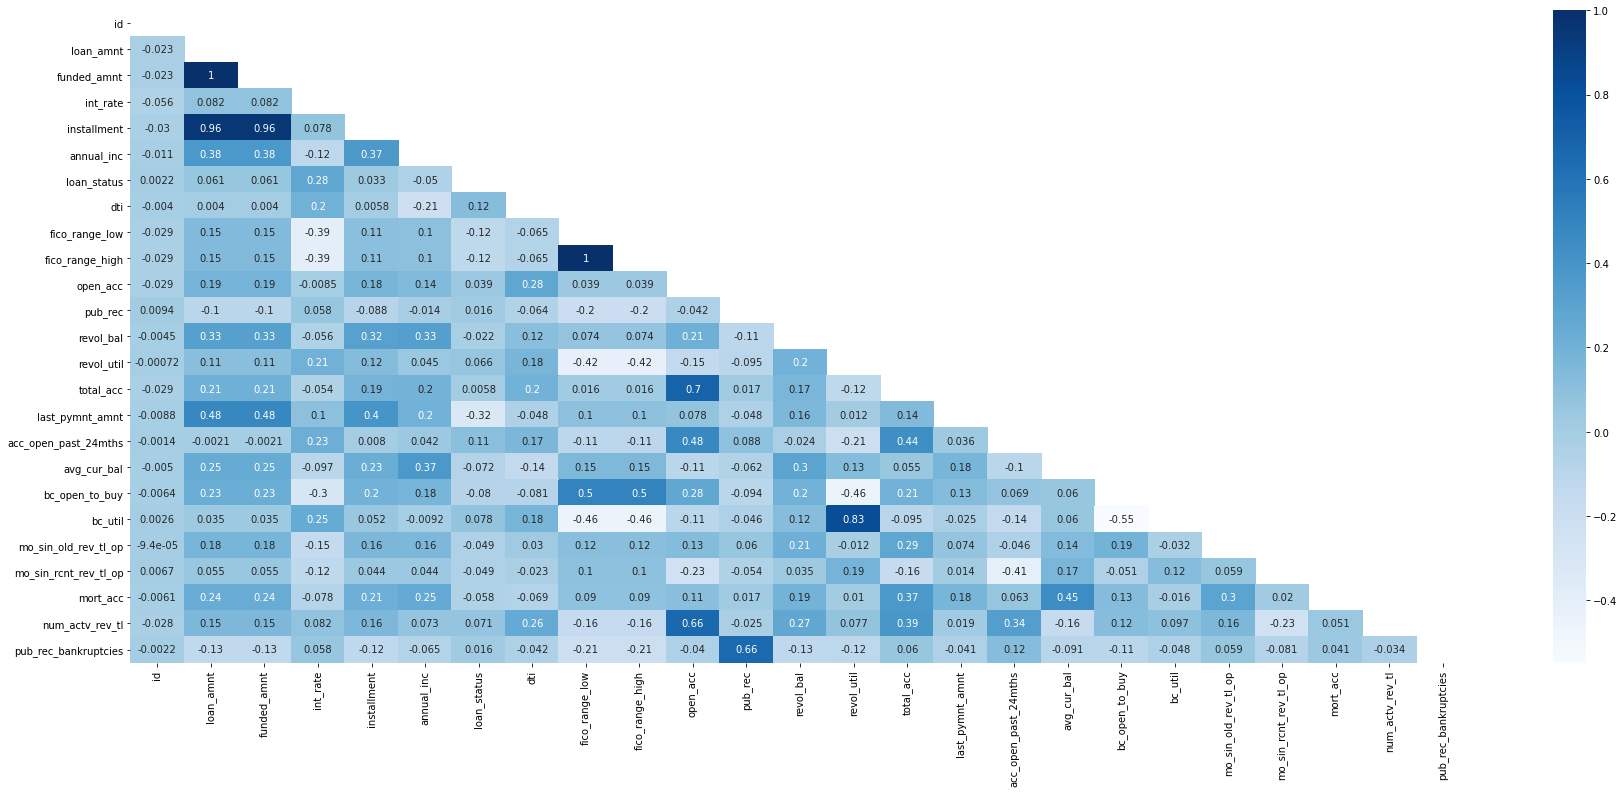

In [225]:
# Let's check te correalation matrix
corr = dataset_1.corr(method='pearson')
plt.figure(figsize=(30,12))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,mask=mask,cmap=mpl.cm.Blues,annot=True)

In [226]:
# Check the correlation between all the features and our target loan_status
print(dataset_1.corr(method='pearson')['loan_status'].sort_values())

last_pymnt_amnt         -0.319081
fico_range_low          -0.121892
fico_range_high         -0.121891
bc_open_to_buy          -0.080077
avg_cur_bal             -0.071977
mort_acc                -0.057858
annual_inc              -0.050349
mo_sin_old_rev_tl_op    -0.049426
mo_sin_rcnt_rev_tl_op   -0.048839
revol_bal               -0.021714
id                       0.002221
total_acc                0.005804
pub_rec_bankruptcies     0.015815
pub_rec                  0.016023
installment              0.032847
open_acc                 0.039430
funded_amnt              0.060818
loan_amnt                0.060818
revol_util               0.066188
num_actv_rev_tl          0.071185
bc_util                  0.077744
acc_open_past_24mths     0.105989
dti                      0.123108
int_rate                 0.282825
loan_status              1.000000
Name: loan_status, dtype: float64


In [227]:
# Drop the features that have less than 0.03 correlation value with loan_status as required
drop_list=[]
for i in range(len(corr)):
    if abs(corr['loan_status'][i]) < 0.03:
        dataset_1 = dataset_1.drop([corr.columns[i]],axis=1)
        drop_list.append(corr.columns[i])
dataset_1.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,last_pymnt_amnt,application_type,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl
0,15000.0,15000.0,60 months,12.39,336.64,C,C1,MANAGEMENT,10+ years,RENT,...,12017.81,Individual,5.0,29828.0,9525.0,4.7,244.0,1.0,0.0,4.0
2,21425.0,21425.0,60 months,15.59,516.36,D,D1,Programming Analysis Supervisor,6 years,RENT,...,17813.19,Individual,4.0,4232.0,324.0,97.8,136.0,7.0,0.0,4.0
5,9600.0,9600.0,36 months,13.66,326.53,C,C3,Admin Specialist,10+ years,RENT,...,9338.58,Individual,8.0,3214.0,6494.0,69.2,265.0,23.0,0.0,7.0
6,2500.0,2500.0,36 months,11.99,83.03,B,B5,Manufacturing Engineer,< 1 year,MORTGAGE,...,2294.26,Individual,6.0,44136.0,1333.0,86.4,148.0,24.0,5.0,4.0
7,16000.0,16000.0,60 months,11.44,351.40,B,B4,Foreign Service Officer,6 years,OWN,...,4935.54,Individual,3.0,53392.0,2559.0,72.2,133.0,17.0,2.0,3.0


In [228]:
# Print the list that we dropped
print(drop_list)

['id', 'pub_rec', 'revol_bal', 'total_acc', 'pub_rec_bankruptcies']


### How large is the resulting dataset ?

In [229]:
# check again the shape
dataset_1.shape

(86138, 34)

<a id='3'></a>
# 4. Feature Engineering and Exploratory Analysis

### Examine the properties of the remaining features.

In [230]:
dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86138 entries, 0 to 99998
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   loan_amnt              86138 non-null  float64
 1   funded_amnt            86138 non-null  float64
 2   term                   86138 non-null  object 
 3   int_rate               86138 non-null  float64
 4   installment            86138 non-null  float64
 5   grade                  86138 non-null  object 
 6   sub_grade              86138 non-null  object 
 7   emp_title              81416 non-null  object 
 8   emp_length             81421 non-null  object 
 9   home_ownership         86138 non-null  object 
 10  annual_inc             86138 non-null  float64
 11  verification_status    86138 non-null  object 
 12  loan_status            86138 non-null  int64  
 13  purpose                86138 non-null  object 
 14  title                  86138 non-null  object 
 15  zi

Text(55000, 1, '0: Fully Paid')

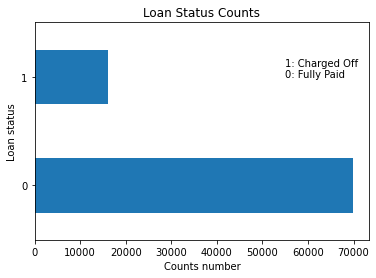

In [231]:
# Check the loan_status target
dataset_1['loan_status'].value_counts().plot(kind='barh')
plt.title('Loan Status Counts')
plt.xlabel('Counts number')
plt.ylabel('Loan status')
plt.text(55000,1.1,"1: Charged Off")
plt.text(55000,1,"0: Fully Paid")

In [232]:
# Check the statistics amoung all features
dataset_1.describe()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,loan_status,dti,fico_range_low,fico_range_high,open_acc,revol_util,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl
count,86138.000000,86138.000000,86138.000000,86138.000000,8.613800e+04,86138.000000,86138.000000,86138.000000,86138.000000,86138.000000,86094.000000,86138.000000,86138.000000,86138.000000,85142.000000,85089.000000,86138.000000,86138.000000,86138.000000,86138.000000
mean,14106.526446,14106.526446,13.002360,430.737187,7.384311e+04,0.187559,18.532747,692.462966,696.463024,11.746453,54.582777,4757.453184,4.594732,13066.638371,8942.506507,63.808959,183.524333,12.796896,1.748880,5.762358
std,8391.139221,8391.139221,4.397419,251.653139,5.929352e+04,0.390362,8.538247,29.731549,29.731848,5.433122,23.515901,6466.767327,3.070996,16232.739293,14100.186250,27.051347,93.266430,16.224586,2.091488,3.224598
min,1000.000000,1000.000000,6.000000,30.420000,4.000000e+03,0.000000,0.000000,660.000000,664.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,7800.000000,7800.000000,9.490000,248.480000,4.500000e+04,0.000000,12.070000,670.000000,674.000000,8.000000,37.200000,358.522500,2.000000,3010.000000,1087.000000,44.100000,118.000000,3.000000,0.000000,3.000000
50%,12000.000000,12000.000000,12.990000,370.480000,6.247372e+04,0.000000,17.950000,685.000000,689.000000,11.000000,54.900000,1241.230000,4.000000,6994.500000,3823.000000,67.700000,167.000000,8.000000,1.000000,5.000000
75%,20000.000000,20000.000000,15.610000,568.005000,9.000000e+04,0.000000,24.500000,705.000000,709.000000,14.000000,72.500000,7303.205000,6.000000,17905.000000,10588.000000,87.500000,232.000000,15.000000,3.000000,7.000000
max,35000.000000,35000.000000,26.060000,1408.130000,7.500000e+06,1.000000,39.990000,845.000000,850.000000,84.000000,180.300000,36234.440000,53.000000,447433.000000,249625.000000,255.200000,718.000000,372.000000,34.000000,38.000000


<a id='3.1'></a>
## 4.1 Feature Analysis and Exploration

<a id='3.1.1'></a>
### 4.1.1. Analysing the categorical features 

### List the categorical features and take a decision on what to do with them - drop them or process them. Explain your decisions.

In [233]:
# List the categorical features
print([column for column in dataset_1.columns if dataset_1[column].dtype == object])

['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'application_type']


In [234]:
# Check the labels number of all categorical features
for i in range(len(dataset_1.select_dtypes(include=['object']).columns)):
    print(str(dataset_1.select_dtypes(include=['object']).columns[i]) + " - labels number = ",len(dataset_1.select_dtypes(include=['object']).iloc[:,i].unique()),"\n")

term - labels number =  2 

grade - labels number =  7 

sub_grade - labels number =  35 

emp_title - labels number =  32988 

emp_length - labels number =  12 

home_ownership - labels number =  4 

verification_status - labels number =  3 

purpose - labels number =  13 

title - labels number =  20 

zip_code - labels number =  846 

addr_state - labels number =  46 

earliest_cr_line - labels number =  598 

initial_list_status - labels number =  2 

application_type - labels number =  1 



<font color='darkblue'> We decide to drop the **emp_title**, **zip_code** and **earliest_cr_line** features as they have too many different labels and intuitively they don not contain much useful information. We will also drop the **application_type** feature as it only has one single label value and thus it has no explanatory power.

In [235]:
# Define a function that plot the percentage of "charge off" and "fully paid" within each feature
def plot_function(feature, dataset = dataset_1, width=0.4):
    """
    plot function showing the charge-off rate and fully paid rate for different feature within the dataset chosen
    feature: categorical feature name within the dataset
    dataset:defauled as our loans dataset
    """
    # generate feature labels to list
    labels = sorted(dataset[feature].unique().tolist())
    #count the values for each feature label
    feature_counts = dataset[feature].value_counts().sort_index()
    #compute the fully paid rate and charge off rate
    fp_percentage = dataset[dataset.loan_status==0][feature].value_counts().sort_index() / feature_counts
    cf_percentage =  dataset[dataset.loan_status==1][feature].value_counts().sort_index() / feature_counts
    x = np.arange(len(labels))
    #Plot
    fig,ax = plt.subplots(figsize=(7,6))
    ax.bar(x-width/2,fp_percentage,width,label='Fully Paid Rate')
    ax.bar(x+width/2,cf_percentage,width,label='Charged Off Rate')
    ax.set_title('Percentage by feature = ' + str(feature))
    ax.set_ylabel('Percentage')
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=90)
    ax.legend()
    plt.tight_layout()
    
    return plt

<module 'matplotlib.pyplot' from '/Users/cenghui/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

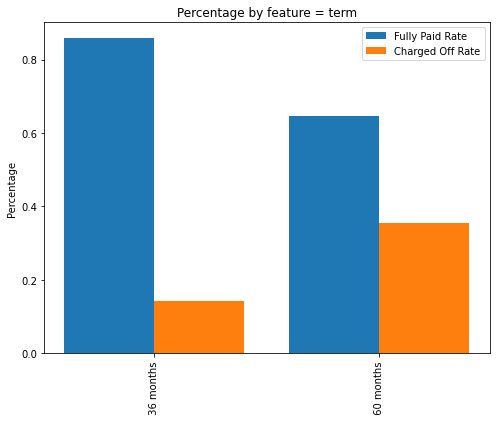

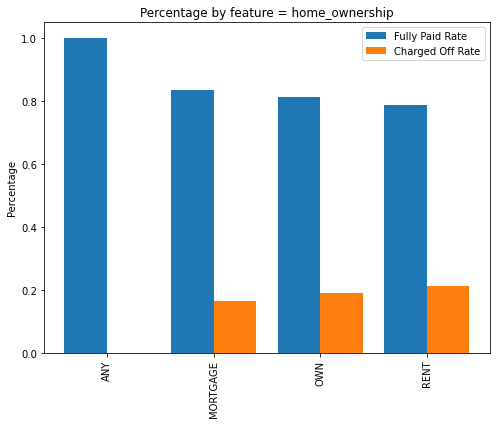

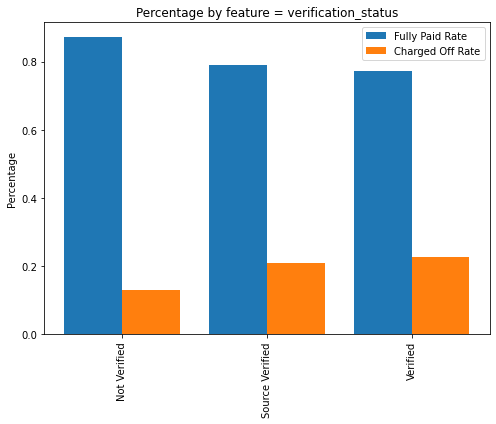

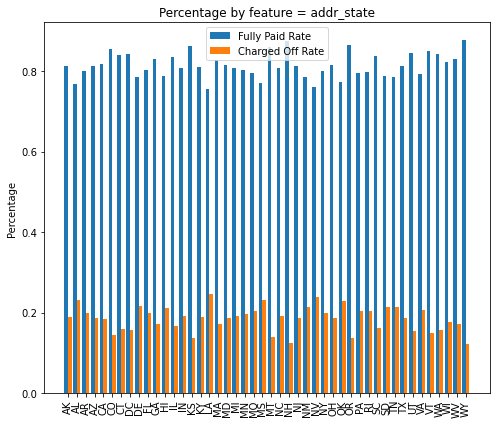

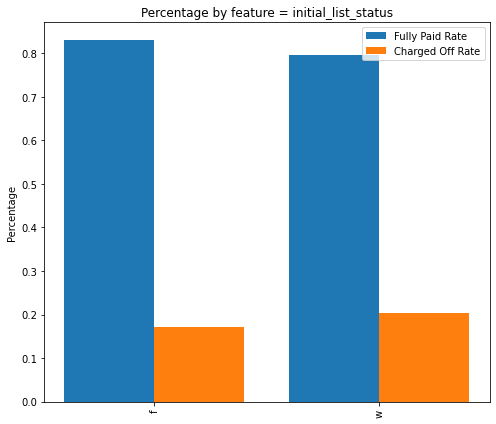

In [236]:
# Let's plot and check the following features' fully paid rate and charge off rate
plot_function(feature='term', dataset = dataset_1,width=0.4)
plot_function(feature='home_ownership', dataset = dataset_1,width=0.4)
plot_function(feature='verification_status',dataset = dataset_1,width=0.4)
plot_function(feature='addr_state',dataset = dataset_1,width=0.4)
plot_function(feature='initial_list_status',dataset = dataset_1,width=0.4)

<font color = 'darkblue'> Description on the plots above and reasons to keep them: As per the plots above, we can notice that these features have distinct charged off rates across their labels. For instance, a 60-month loan tends to have a higher default rate than a 36-month loan; People who are paying mortgagae or already own a property are less likely to default than those who rent etc. Since these feature all express some explanatory power, we decide to process them.

<module 'matplotlib.pyplot' from '/Users/cenghui/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

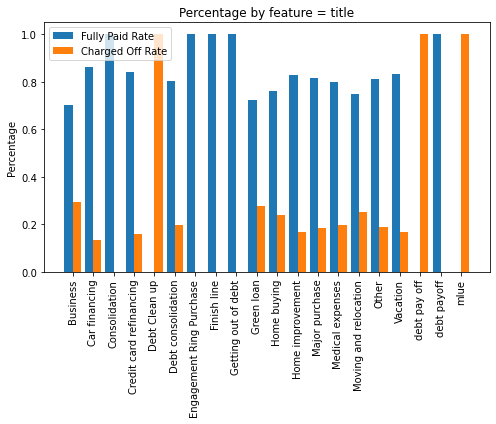

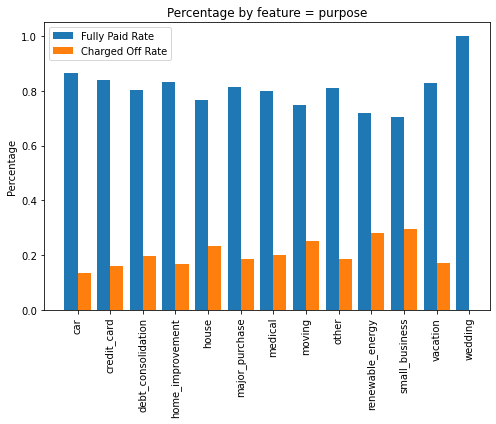

In [237]:
# Let's plot the percentage for title and purpose feature
plot_function(feature='title', dataset = dataset_1,width=0.4)
plot_function(feature='purpose', dataset = dataset_1,width=0.4)

<font color = 'darkblue'> The reason that we drop the feature 'purpose' is that the information in these two features are very similar and we decided to drop the feature 'purpose' in stead of 'title 'because 'title' has more labels and we think it is more precise and helpful to our predictions. 

In [238]:
# Drop the features that we decided previously
droplist=['zip_code','earliest_cr_line','application_type','emp_title','purpose']
for i in range(len(droplist)):
    dataset_1 = dataset_1.drop([droplist[i]],axis=1)
dataset_1

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,initial_list_status,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl
0,15000.0,15000.0,60 months,12.39,336.64,C,C1,10+ years,RENT,78000.0,...,w,12017.81,5.0,29828.0,9525.0,4.7,244.0,1.0,0.0,4.0
2,21425.0,21425.0,60 months,15.59,516.36,D,D1,6 years,RENT,63800.0,...,w,17813.19,4.0,4232.0,324.0,97.8,136.0,7.0,0.0,4.0
5,9600.0,9600.0,36 months,13.66,326.53,C,C3,10+ years,RENT,69000.0,...,f,9338.58,8.0,3214.0,6494.0,69.2,265.0,23.0,0.0,7.0
6,2500.0,2500.0,36 months,11.99,83.03,B,B5,< 1 year,MORTGAGE,89000.0,...,f,2294.26,6.0,44136.0,1333.0,86.4,148.0,24.0,5.0,4.0
7,16000.0,16000.0,60 months,11.44,351.40,B,B4,6 years,OWN,109777.0,...,w,4935.54,3.0,53392.0,2559.0,72.2,133.0,17.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99967,3600.0,3600.0,36 months,12.99,121.29,C,C1,1 year,OWN,52500.0,...,w,425.71,3.0,44549.0,1449.0,58.6,214.0,3.0,3.0,2.0
99978,28250.0,28250.0,60 months,15.61,681.15,D,D1,9 years,MORTGAGE,82000.0,...,w,681.15,7.0,18704.0,45883.0,31.4,303.0,2.0,6.0,8.0
99986,19200.0,19200.0,36 months,6.03,584.37,A,A1,8 years,MORTGAGE,79000.0,...,f,584.37,1.0,24442.0,29266.0,11.0,255.0,88.0,1.0,1.0
99992,8800.0,8800.0,36 months,22.15,336.76,E,E5,3 years,MORTGAGE,62000.0,...,f,336.76,14.0,10831.0,5378.0,28.3,115.0,2.0,1.0,6.0


### Convert Term to a numerical feature

In [239]:
dataset_1.term.unique()

array([' 60 months', ' 36 months'], dtype=object)

In [240]:
# Convert the Term to numerical feature
term_values = {' 36 months':36, ' 60 months':60}
dataset_1['term'] = dataset_1.term.map(term_values)

In [241]:
dataset_1[['term']]

,term
0,60
2,60
5,36
6,36
7,60
...,...
99967,36
99978,60
99986,36
99992,36


### Decide if you want to do anything to emp_length

In [242]:
# Lets convert the labels to numeric values first
package = {'emp_length': {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, 
                         '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}}
dataset_1 = dataset_1.replace(package)

In [243]:
# Compute the fully paid rate and charged off rate for each label
for year in dataset_1.emp_length.unique():
    print(f"{year} fully paid and charged off rate:")
    print(f"{dataset_1[dataset_1.emp_length == year].loan_status.value_counts(normalize=True)}","\n")
    print('-----------------------------------------',"\n")

10.0 fully paid and charged off rate:
0    0.818079
1    0.181921
Name: loan_status, dtype: float64 

----------------------------------------- 

6.0 fully paid and charged off rate:
0    0.811358
1    0.188642
Name: loan_status, dtype: float64 

----------------------------------------- 

0.0 fully paid and charged off rate:
0    0.799433
1    0.200567
Name: loan_status, dtype: float64 

----------------------------------------- 

2.0 fully paid and charged off rate:
0    0.820366
1    0.179634
Name: loan_status, dtype: float64 

----------------------------------------- 

8.0 fully paid and charged off rate:
0    0.808984
1    0.191016
Name: loan_status, dtype: float64 

----------------------------------------- 

9.0 fully paid and charged off rate:
0    0.809067
1    0.190933
Name: loan_status, dtype: float64 

----------------------------------------- 

7.0 fully paid and charged off rate:
0    0.814273
1    0.185727
Name: loan_status, dtype: float64 

----------------------------

In [244]:
# We only concern about the charge off rate which is the default rate
chargeOff_rate =  dataset_1[dataset_1.loan_status==1]['emp_length'].value_counts().sort_index() / dataset_1['emp_length'].value_counts().sort_index()
chargeOff_rate

0.0     0.200567
1.0     0.190259
2.0     0.179634
3.0     0.184257
4.0     0.175262
5.0     0.172605
6.0     0.188642
7.0     0.185727
8.0     0.191016
9.0     0.190933
10.0    0.181921
Name: emp_length, dtype: float64

<font color='darkblue'>We can see that the rates are not much different across different employment lengths, thus we drop this columns.

In [245]:
# We drop 'emp_length'
dataset_1 = dataset_1.drop(['emp_length'],axis=1)

### Is sub_grade worth keeping ?

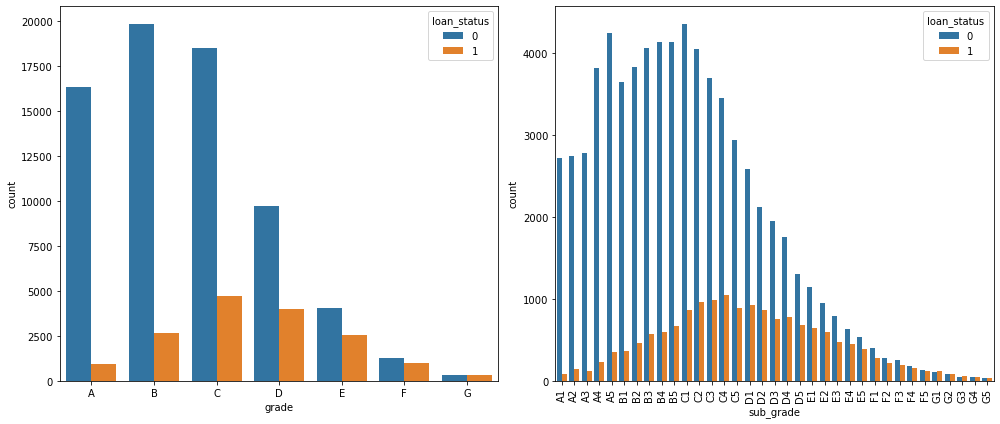

In [246]:
# Let look at the distribution of grade and sub_grade features
plt.figure(figsize=(14, 6))
# Plot by grade
plt.subplot(1,2,1)
grade = sorted(dataset_1.grade.unique().tolist())
sns.countplot(x='grade', data=dataset_1, hue='loan_status', order=grade)

# Plot by subgrade
plt.subplot(1,2,2)
sub_grade = sorted(dataset_1.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=dataset_1, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

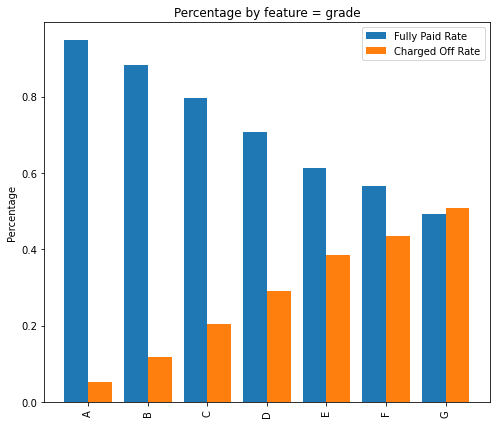

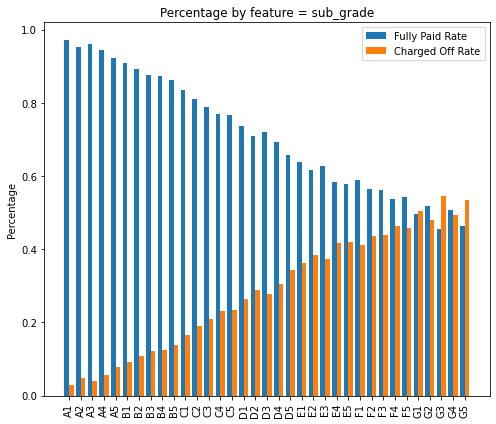

In [247]:
# Compute and plot their chargeoff rate
plot_function(feature='grade', dataset = dataset_1,width=0.4);
plot_function(feature='sub_grade', dataset = dataset_1,width=0.4);

<font color='darkblue'>Clearly we can see that the grade is implied by sub_grade feature and they have nearly the same distribution in terms of both counts and percentage. **Thus we drop grade and keep the sub_grade feature**.

In [248]:
# Drop grade
dataset_1 = dataset_1.drop(['grade'],axis=1)
dataset_1.head()

,loan_amnt,funded_amnt,term,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,loan_status,...,initial_list_status,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl
0,15000.0,15000.0,60,12.39,336.64,C1,RENT,78000.0,Source Verified,0,...,w,12017.81,5.0,29828.0,9525.0,4.7,244.0,1.0,0.0,4.0
2,21425.0,21425.0,60,15.59,516.36,D1,RENT,63800.0,Source Verified,0,...,w,17813.19,4.0,4232.0,324.0,97.8,136.0,7.0,0.0,4.0
5,9600.0,9600.0,36,13.66,326.53,C3,RENT,69000.0,Source Verified,0,...,f,9338.58,8.0,3214.0,6494.0,69.2,265.0,23.0,0.0,7.0
6,2500.0,2500.0,36,11.99,83.03,B5,MORTGAGE,89000.0,Source Verified,0,...,f,2294.26,6.0,44136.0,1333.0,86.4,148.0,24.0,5.0,4.0
7,16000.0,16000.0,60,11.44,351.40,B4,OWN,109777.0,Verified,0,...,w,4935.54,3.0,53392.0,2559.0,72.2,133.0,17.0,2.0,3.0


<a id='3.1.2'></a>
### 4.1.2. Analysing the continuous features 

### Do you want to do anything to Annual Income ?

#### Feature : Annual Income

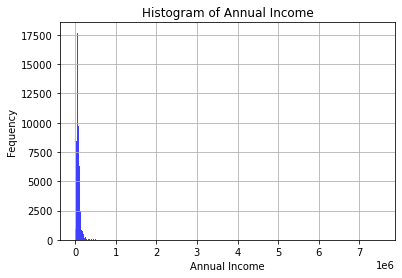

In [249]:
# Plot the distribution of annual income
plt.hist(dataset_1['annual_inc'], bins = 500, facecolor='b', alpha=0.75) 
plt.xlabel('Annual Income')
plt.ylabel('Fequency')
plt.title('Histogram of Annual Income')
plt.grid(True)
plt.show()

<font color ='darkblue'>As we can see that the figure above is not very clear as it has outliers. We will show a new and clearer distribution chart below.

In [250]:
# We look for the max and min value in 'annual_inc'
print(dataset_1['annual_inc'].max())
print(dataset_1['annual_inc'].min())

7500000.0
4000.0


In [251]:
annual_inc=pd.cut(x=dataset_1['annual_inc'], bins=[0, 50000, 100000, 150000, 200000, 8000000])
annual_inc.value_counts()

(50000, 100000]      41543
(0, 50000]           29827
(100000, 150000]     10650
(150000, 200000]      2460
(200000, 8000000]     1658
Name: annual_inc, dtype: int64

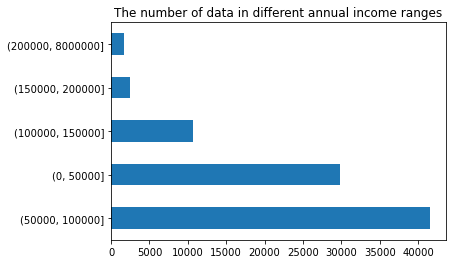

In [252]:
pr = annual_inc.value_counts()
pr.plot(kind='barh', title='The number of data in different annual income ranges');

<font color='darkblue'>We can see that the annual income feature is very 'unbalanced' in terms of value.

In [253]:
# Check the statistics of annual_income
dataset_1.groupby('loan_status')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,69982.0,75277.520514,55816.645504,4000.0,45000.0,65000.0,90000.0,4900000.0
1,16156.0,67629.772470,72125.748438,4000.0,42000.0,59000.0,80000.0,7500000.0


<font color='darkblue'>We believe it is necessary to standardise the feauture 'annual income'. We did not do it here because we are going to standardise all the features later. So we just keep it unchanged and process to following part at this point.

### How do you want to treat the two FICO scores ?

In [254]:
# Check the data info and find the two FICO scores: FICO_range_low and FICO_range_high
dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86138 entries, 0 to 99998
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   loan_amnt              86138 non-null  float64
 1   funded_amnt            86138 non-null  float64
 2   term                   86138 non-null  int64  
 3   int_rate               86138 non-null  float64
 4   installment            86138 non-null  float64
 5   sub_grade              86138 non-null  object 
 6   home_ownership         86138 non-null  object 
 7   annual_inc             86138 non-null  float64
 8   verification_status    86138 non-null  object 
 9   loan_status            86138 non-null  int64  
 10  title                  86138 non-null  object 
 11  addr_state             86138 non-null  object 
 12  dti                    86138 non-null  float64
 13  fico_range_low         86138 non-null  float64
 14  fico_range_high        86138 non-null  float64
 15  op

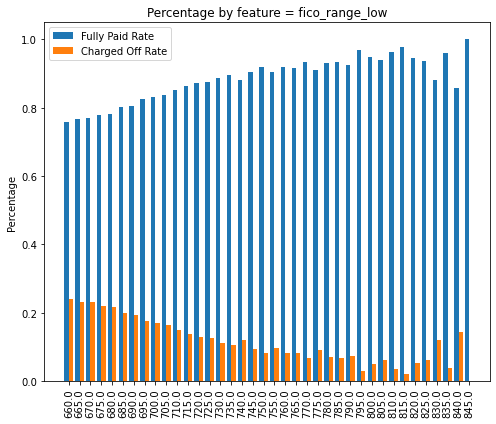

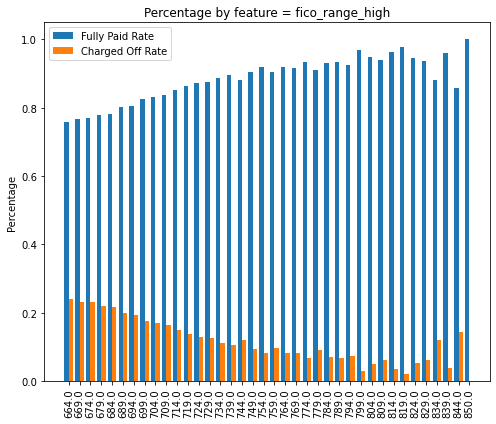

In [255]:
# Plot their fully paid rate and defalut rate
fico_range = dataset_1
plot_function(feature='fico_range_low', dataset = dataset_1,width=0.4);
plot_function(feature='fico_range_high', dataset = dataset_1,width=0.4);

<font color='darkblue'>We notice they have almost the same rate across different label, let's check their correlation to be certain.

In [256]:
dataset_1[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


<font color='darkblue'>The two features are perfectly correlated! We take an average score of the two and replace the orginal ones.

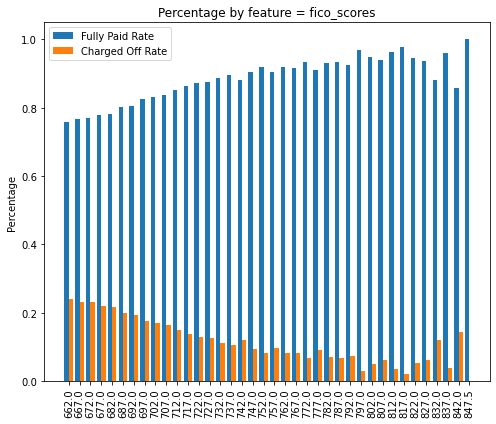

In [257]:
# Compute the average score and replace the old two.
# Plot the new feature
dataset_1['fico_scores'] = 0.5*(dataset_1['fico_range_low'] + dataset_1['fico_range_high'])
dataset_1.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)
plot_function(feature='fico_scores', dataset = dataset_1,width=0.4);

<a id='3.2'></a>
## 4.2. Encoding Categorical Data

### Decide how to handle the categorical data in columns ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type']

### You may wish to use a LabelEncoder


In [258]:
# We have already dropped 'grade', 'purpose', 'application_type' 
categorical_features = dataset_1.select_dtypes(include=['object'])
categorical_features.head()

,sub_grade,home_ownership,verification_status,title,addr_state,initial_list_status
0,C1,RENT,Source Verified,Debt consolidation,VA,w
2,D1,RENT,Source Verified,Credit card refinancing,MO,w
5,C3,RENT,Source Verified,Debt consolidation,NJ,f
6,B5,MORTGAGE,Source Verified,Home improvement,MN,f
7,B4,OWN,Verified,Debt consolidation,VA,w


In [259]:
# Encode the categorical features above using LabelEncoder
for i in range(len(categorical_features.columns)):
    col_name = categorical_features.columns[i]
    X = categorical_features[[col_name]].values
    le = LabelEncoder()
    X[:,0] = le.fit_transform(X[:,0])
    categorical_features[col_name] = X[:,0] #update the orginal dataframe

In [260]:
# Have a look at the encoded features
categorical_features.head()

,sub_grade,home_ownership,verification_status,title,addr_state,initial_list_status
0,10,3,1,5,40,1
2,15,3,1,3,21,1
5,12,3,1,5,26,0
6,9,1,1,11,20,0
7,8,2,2,5,40,1


In [261]:
# Check the whole dataset after encoding
numerical_features = dataset_1.select_dtypes(exclude=['object'])
dataset_loans = pd.concat([numerical_features,categorical_features],axis=1)
dataset_loans

,loan_amnt,funded_amnt,term,int_rate,installment,annual_inc,loan_status,dti,open_acc,revol_util,...,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,fico_scores,sub_grade,home_ownership,verification_status,title,addr_state,initial_list_status
0,15000.0,15000.0,60,12.39,336.64,78000.0,0,12.03,6.0,29.0,...,1.0,0.0,4.0,752.0,10,3,1,5,40,1
2,21425.0,21425.0,60,15.59,516.36,63800.0,0,18.49,10.0,76.2,...,7.0,0.0,4.0,687.0,15,3,1,3,21,1
5,9600.0,9600.0,36,13.66,326.53,69000.0,0,25.81,12.0,59.4,...,23.0,0.0,7.0,682.0,12,3,1,5,26,0
6,2500.0,2500.0,36,11.99,83.03,89000.0,0,13.77,9.0,94.3,...,24.0,5.0,4.0,687.0,9,1,1,11,20,0
7,16000.0,16000.0,60,11.44,351.40,109777.0,0,11.63,7.0,60.4,...,17.0,2.0,3.0,702.0,8,2,2,5,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99967,3600.0,3600.0,36,12.99,121.29,52500.0,1,31.43,5.0,54.1,...,3.0,3.0,2.0,662.0,10,2,0,15,4,1
99978,28250.0,28250.0,60,15.61,681.15,82000.0,1,16.54,18.0,29.0,...,2.0,6.0,8.0,717.0,15,1,2,5,10,1
99986,19200.0,19200.0,36,6.03,584.37,79000.0,1,8.61,7.0,9.0,...,88.0,1.0,1.0,832.0,0,1,0,1,10,0
99992,8800.0,8800.0,36,22.15,336.76,62000.0,1,21.45,15.0,32.9,...,2.0,1.0,6.0,677.0,24,1,2,5,15,0


<font color='darkblue'>We notice that the features 'loan_amount' and 'funded_amount' seem completely the same, let's check if so.

In [262]:
# Let's check if the data in 'loan_amnt' and 'funded_amnt' are completely same
mask = dataset_loans['loan_amnt'] == dataset_loans['funded_amnt']
print('The number of same data between "loan_amnt" and "funded_amnt" is: ', dataset_loans[mask].shape[0])

The number of same data between "loan_amnt" and "funded_amnt" is:  86138


<font color='darkblue'>After check, it proves that the 'loan_amnt' and 'funded_amount' are the same, therefore we drop one of them.

In [263]:
dataset_loans = dataset_loans.drop(['loan_amnt'],axis=1)

<a id='3.4'></a>
## 4.3. Sampling Data

### To create a balanced dataset, draw 5500 rows at random from each of the two classes and combine them into a new dataframe.

In [264]:
# Split the fully paid and charge off classes in order to draw data from them
loans_0 = dataset_loans[dataset_loans.loan_status == 0]
loans_1 = dataset_loans[dataset_loans.loan_status == 1]
print(loans_0.shape)
print(loans_1.shape)

(69982, 25)
(16156, 25)


In [265]:
# Draw 5500 rows randomly from fully paid class
loans0_5500 = loans_0.sample(n=5500,random_state=1)

In [266]:
# Draw 5500 rows from charged off class
loans1_5500 = loans_1.sample(n=5500,random_state=1)

In [267]:
# Combine the 2 class and creat a balanced dataset
loans_new = pd.concat([loans0_5500,loans1_5500],axis=0)
loans_new.index = np.arange(11000)
loans_new

,funded_amnt,term,int_rate,installment,annual_inc,loan_status,dti,open_acc,revol_util,last_pymnt_amnt,...,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,fico_scores,sub_grade,home_ownership,verification_status,title,addr_state,initial_list_status
0,9000.0,36,9.17,286.92,76000.0,0,4.79,7.0,12.1,282.43,...,0.0,0.0,4.0,662.0,5,2,0,5,4,1
1,17500.0,60,21.99,483.24,45000.0,0,31.44,15.0,52.0,1162.47,...,6.0,4.0,6.0,707.0,24,1,1,3,12,1
2,30000.0,60,11.44,658.88,84739.0,0,23.17,15.0,38.5,29154.95,...,26.0,4.0,5.0,742.0,8,1,2,5,29,1
3,6000.0,36,7.69,187.17,58000.0,0,15.27,11.0,79.8,1287.14,...,58.0,0.0,3.0,692.0,3,3,0,3,17,1
4,6000.0,36,14.31,205.98,70000.0,0,16.03,9.0,20.0,5969.68,...,13.0,4.0,1.0,677.0,13,1,0,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,22750.0,60,23.43,646.97,60000.0,1,17.88,4.0,93.6,646.97,...,69.0,0.0,1.0,697.0,25,3,1,5,4,1
10996,15550.0,60,24.99,456.33,52000.0,1,20.33,9.0,85.9,456.33,...,0.0,0.0,4.0,672.0,28,3,2,5,33,1
10997,4800.0,36,13.98,164.01,90000.0,1,36.79,13.0,44.1,164.01,...,4.0,0.0,2.0,757.0,12,3,2,5,29,0
10998,10000.0,60,17.57,251.61,39000.0,1,20.55,10.0,33.4,251.61,...,17.0,0.0,6.0,677.0,18,3,1,5,37,1


### Choose a method to handle any NAs that may be in a column.

In [268]:
# Have a look at the new dataset info
loans_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11000 entries, 0 to 10999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funded_amnt            11000 non-null  float64
 1   term                   11000 non-null  int64  
 2   int_rate               11000 non-null  float64
 3   installment            11000 non-null  float64
 4   annual_inc             11000 non-null  float64
 5   loan_status            11000 non-null  int64  
 6   dti                    11000 non-null  float64
 7   open_acc               11000 non-null  float64
 8   revol_util             10996 non-null  float64
 9   last_pymnt_amnt        11000 non-null  float64
 10  acc_open_past_24mths   11000 non-null  float64
 11  avg_cur_bal            11000 non-null  float64
 12  bc_open_to_buy         10856 non-null  float64
 13  bc_util                10847 non-null  float64
 14  mo_sin_old_rev_tl_op   11000 non-null  float64
 15  mo

<font color='darkblue'>There are not too many missing values, unlikely causing serious problems. We fill the NAs in order to make sure that we have a perfect balanced dataset.

In [269]:
# Fill the NA with the previous value
loans_new = loans_new.fillna(method='ffill')
loans_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11000 entries, 0 to 10999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funded_amnt            11000 non-null  float64
 1   term                   11000 non-null  int64  
 2   int_rate               11000 non-null  float64
 3   installment            11000 non-null  float64
 4   annual_inc             11000 non-null  float64
 5   loan_status            11000 non-null  int64  
 6   dti                    11000 non-null  float64
 7   open_acc               11000 non-null  float64
 8   revol_util             11000 non-null  float64
 9   last_pymnt_amnt        11000 non-null  float64
 10  acc_open_past_24mths   11000 non-null  float64
 11  avg_cur_bal            11000 non-null  float64
 12  bc_open_to_buy         11000 non-null  float64
 13  bc_util                11000 non-null  float64
 14  mo_sin_old_rev_tl_op   11000 non-null  float64
 15  mo

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

### Use an 80:20 split

In [270]:
# Split the target feature
loans_features = loans_new.drop(['loan_status'],axis=1)
loans_target = loans_new[['loan_status']]

In [271]:
# train-test split as required
X_train,X_test,y_train,y_test = train_test_split(loans_features,loans_target,test_size=0.2, random_state=111)

In [272]:
# Check training set shape
print(X_train.shape)
print(y_train.shape)

(8800, 24)
(8800, 1)


In [273]:
# Check testing set shape
print(X_test.shape)
print(y_test.shape)

(2200, 24)
(2200, 1)


<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


### Use K-Folds cross validation with 10 folds and 'roc-auc' as your score.

In [274]:
# DO THIS HERE
k_fold = KFold(n_splits=10)

In [275]:
# Obtain 10 folds through KFold split
for train, test in k_fold.split(X_train):
    print(train.shape,test.shape)

(7920,) (880,)
(7920,) (880,)
(7920,) (880,)
(7920,) (880,)
(7920,) (880,)
(7920,) (880,)
(7920,) (880,)
(7920,) (880,)
(7920,) (880,)
(7920,) (880,)


<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

### Use a wide range of classification models. I have added them below to a Python list.

In [276]:
# Spot check the algorithms
models = []
models.append(('LR', LogisticRegression(random_state=111)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier(random_state=111)))
models.append(('NB', GaussianNB()))
# Neural Network
models.append(('NN', MLPClassifier(random_state=111)))
# Boosting methods
models.append(('AB',AdaBoostClassifier(random_state=111)))
# Bagging methods
models.append(('RF', RandomForestClassifier(random_state=111)))

### K-folds cross validation

In [277]:
from sklearn.metrics import roc_curve,auc,roc_auc_score

<font color='darkblue'>The dataset we currently have is a not scaled dataset. We are concerned that the scaling could have some impact especially on the Logistic Regression, KNN and Neural Network. We decided to do two sets of classification in order to capture the impact of feature scaling for our dataset.

### Cross-Validation with Unscaled Dataset

In [278]:
# Do a 10-fold cross validation using roc_auc score, print the results
result = {}
for model in models:

    print("----------------------------------------------------","\n")    
    print(model[1].__class__)         
    scores = cross_val_score(model[1],X_train,y_train,cv=10,scoring="roc_auc")
    result[model[0]] = scores
    print("AUC Score = ", scores,"\n")
        
print("----------------------------------------------------","\n")

---------------------------------------------------- 

<class 'sklearn.linear_model._logistic.LogisticRegression'>
AUC Score =  [0.90291904 0.87339614 0.88299862 0.87408314 0.86808612 0.8871361
 0.9005403  0.86331329 0.87037955 0.87126284] 

---------------------------------------------------- 

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
AUC Score =  [0.81292519 0.77605426 0.78449193 0.78034412 0.80587667 0.80871506
 0.78826525 0.78104403 0.78677245 0.76433656] 

---------------------------------------------------- 

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
AUC Score =  [0.81228208 0.79197401 0.79650923 0.79666419 0.80335854 0.81589496
 0.80350317 0.77379181 0.78626625 0.78750077] 

---------------------------------------------------- 

<class 'sklearn.naive_bayes.GaussianNB'>
AUC Score =  [0.90716511 0.8924203  0.90375834 0.88917643 0.90045249 0.9062274
 0.91133598 0.88082398 0.88992541 0.89505465] 

-------------------------------------------------

#### Plot a model comparison using a BoxPlot to capture the range of values coming from the K Folds for each model

In [279]:
df_auc = pd.DataFrame(result)
df_auc

,LR,KNN,DT,NB,NN,AB,RF
0,0.902919,0.812925,0.812282,0.907165,0.880000,0.931611,0.936578
1,0.873396,0.776054,0.791974,0.892420,0.873218,0.927170,0.921316
2,0.882999,0.784492,0.796509,0.903758,0.812140,0.931292,0.928152
3,0.874083,0.780344,0.796664,0.889176,0.828263,0.919112,0.931509
4,0.868086,0.805877,0.803359,0.900452,0.861180,0.926060,0.925249
5,0.887136,0.808715,0.815895,0.906227,0.800714,0.937757,0.939255
6,0.900540,0.788265,0.803503,0.911336,0.909977,0.939950,0.937473
7,0.863313,0.781044,0.773792,0.880824,0.865297,0.912493,0.915985
8,0.870380,0.786772,0.786266,0.889925,0.797085,0.922214,0.924128
9,0.871263,0.764337,0.787501,0.895055,0.862611,0.929926,0.925693


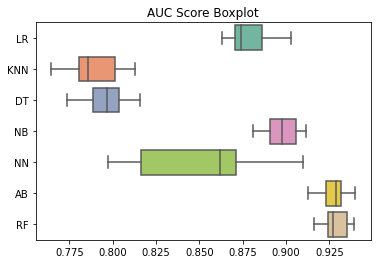

In [280]:
# Boxplot to capture the range of values for each model
sns.boxplot(data=df_auc, orient="h", palette="Set2").set_title('AUC Score Boxplot');

<font color='darkblue'>As we can see from the boxplot above, when applying on unscaled data, the RnadomForestClassifier algorithm has best AUC score, while the KNN is the worst model in terms of AUC score. We believe that it is mainly because the model needs feature scalling and we will work on this point afterwards.

In [281]:
# Average AUC score of models cross validation
df_auc.mean()

LR     0.879412
KNN    0.788883
DT     0.796775
NB     0.897634
NN     0.849048
AB     0.927759
RF     0.928534
dtype: float64

### Cross-Validate with standardized dataset and rerun the all the models to see the differences

In [282]:
# Standardize the dataset
from sklearn.preprocessing import StandardScaler
df_feature_std = pd.DataFrame()
for i in range(len(loans_new.columns)):
    scale = StandardScaler().fit_transform(loans_new[[loans_new.columns[i]]])
    scale = pd.DataFrame(scale,columns=[loans_new.columns[i]])
    df_feature_std = pd.concat([df_feature_std, scale],axis=1)

In [283]:
# Repeat the train test split on the standardized dataset
loan_fts = df_feature_std.drop(['loan_status'],axis=1)
loans_sts = df_feature_std[['loan_status']].replace({'loan_status': {-1: 0}}) # We keep the labels as they were
x_train,x_test,Y_train,Y_test = train_test_split(loan_fts,loans_sts,test_size=0.2, random_state=111)

# Check the shape
print(x_train.shape)
print(x_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(8800, 24)
(2200, 24)
(8800, 1)
(2200, 1)


<font color='darkblue'>Use Standardized data to run all models.

In [284]:
# Do a 10-fold cross validation using roc_auc score, print the results
result = {}
for model in models:

    print("----------------------------------------------------","\n")    
    print(model[1].__class__)         
    scores = cross_val_score(model[1],x_train,Y_train,cv=10,scoring="roc_auc")
    result[model[0]] = scores
    print("AUC Score = ", scores,"\n")
        
print("----------------------------------------------------","\n")

---------------------------------------------------- 

<class 'sklearn.linear_model._logistic.LogisticRegression'>
AUC Score =  [0.9208331  0.91589702 0.92194054 0.91820595 0.91657369 0.92254489
 0.9380669  0.9029887  0.91221926 0.91619145] 

---------------------------------------------------- 

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
AUC Score =  [0.81476928 0.80897591 0.80480485 0.80444069 0.79901186 0.81640375
 0.83986239 0.76668165 0.80381051 0.79281338] 

---------------------------------------------------- 

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
AUC Score =  [0.81228208 0.79311556 0.79650923 0.79438108 0.80450009 0.81589496
 0.80350317 0.77379181 0.78626625 0.78750077] 

---------------------------------------------------- 

<class 'sklearn.naive_bayes.GaussianNB'>
AUC Score =  [0.9062973  0.89205355 0.90280274 0.88950185 0.89898035 0.90842786
 0.91230191 0.88094795 0.88875287 0.89531292] 

-----------------------------------------------

In [285]:
pd.DataFrame(result)

,LR,KNN,DT,NB,NN,AB,RF
0,0.920833,0.814769,0.812282,0.906297,0.919790,0.931570,0.936562
1,0.915897,0.808976,0.793116,0.892054,0.905742,0.927170,0.921517
2,0.921941,0.804805,0.796509,0.902803,0.907467,0.931292,0.928010
3,0.918206,0.804441,0.794381,0.889502,0.904621,0.919112,0.931651
4,0.916574,0.799012,0.804500,0.898980,0.897715,0.926060,0.925241
5,0.922545,0.816404,0.815895,0.908428,0.907860,0.937757,0.939162
6,0.938067,0.839862,0.803503,0.912302,0.921853,0.939950,0.937643
7,0.902989,0.766682,0.773792,0.880948,0.886811,0.912493,0.916070
8,0.912219,0.803811,0.786266,0.888753,0.901961,0.922214,0.924477
9,0.916191,0.792813,0.787501,0.895313,0.903071,0.929926,0.925683


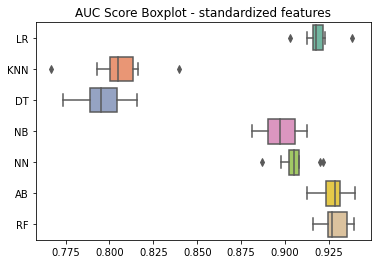

In [286]:
df_auc_new =  pd.DataFrame(result)
sns.boxplot(data=df_auc_new, orient="h", palette="Set2").set_title('AUC Score Boxplot - standardized features');

In [287]:
df_auc_new.mean()

LR     0.918546
KNN    0.805157
DT     0.796775
NB     0.897538
NN     0.905689
AB     0.927755
RF     0.928602
dtype: float64

In [288]:
# Let's check the difference before and after the standardization
df_auc_new.mean()-df_auc.mean()

LR     0.039135
KNN    0.016275
DT     0.000000
NB    -0.000096
NN     0.056640
AB    -0.000004
RF     0.000068
dtype: float64

<font color = 'darkblue'> After the standardization, Logistic model,KNN model and Neural network model perform much better. RandomForest model continues to be the best model.

<a id='5'></a>
# 6. Model Tuning and Grid Search

### Choose the best model and do some hyperparameter tuning by looping over the hyper parameters of the model to fine-tune the model. 

<font color='darkblue'>We can see from the boxplot, the RandomForest model shows highest average auc score.

In [302]:
best_model = RandomForestClassifier(random_state=111)
parameters = {'n_estimators':[100,150,200,300],'max_leaf_nodes':[10,20,30,40] }

In [303]:
# Model tuning using grid search - original dataset not standardized
grid = GridSearchCV(best_model, parameters, verbose=3,scoring='roc_auc',return_train_score=True) 
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] max_leaf_nodes=10, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_leaf_nodes=10, n_estimators=100, score=(train=0.925, test=0.920), total=   0.6s
[CV] max_leaf_nodes=10, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  max_leaf_nodes=10, n_estimators=100, score=(train=0.924, test=0.921), total=   0.6s
[CV] max_leaf_nodes=10, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  max_leaf_nodes=10, n_estimators=100, score=(train=0.924, test=0.922), total=   0.7s
[CV] max_leaf_nodes=10, n_estimators=100 .............................
[CV]  max_leaf_nodes=10, n_estimators=100, score=(train=0.926, test=0.917), total=   0.6s
[CV] max_leaf_nodes=10, n_estimators=100 .............................
[CV]  max_leaf_nodes=10, n_estimators=100, score=(train=0.924, test=0.915), total=   0.6s
[CV] max_leaf_nodes=10, n_estimators=150 .............................
[CV]  max_leaf_nodes=10, n_estimators=150, score=(train=0.925, test=0.920), total=   0.8s
[CV] max_leaf_nodes=10, n_estimators=150 .............................
[CV]  max_leaf_nodes=10, n_estimators=150, score=(train=0.924, test=0.920), total=   0.9s
[CV] max_leaf_nodes=10, n_estimators=150 .............................
[CV]  max_leaf_nodes=10, n_estimators=150, score=(train=0.924, test=0.922), total=   0.8s
[CV] max_leaf_nodes=10, n_estimators=150 .............................
[CV]  max_leaf_nodes=10, n_estimat

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.9min finished


GridSearchCV(estimator=RandomForestClassifier(random_state=111),
             param_grid={'max_leaf_nodes': [10, 20, 30, 40],
                         'n_estimators': [100, 150, 200, 300]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [304]:
# Obtain the best parameter after tuning
best_param = grid.best_params_
best_param

{'max_leaf_nodes': 40, 'n_estimators': 300}

<a id='6'></a>
# 7. Finalise the Model

### Finalize Model with best parameters found during tuning step.

In [305]:
# Assign the best parameters to our final model
final_model = RandomForestClassifier(max_leaf_nodes= best_param['max_leaf_nodes'], n_estimators= best_param['n_estimators'], random_state=111)

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

### Calculate the fine-tuned model results on the test dataset. Calculate accuracy, confusion matrix, the classification report.

[[878 201]
 [124 997]]
Test Accuracy: 0.852


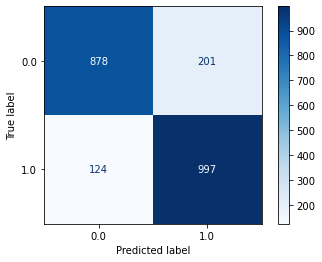

In [306]:
# Since the RandomForest Classifier has the best performance on both scaled and unscaled dataset, it does not matter too much on the dataset we chose.
# Here we only use the scaled dataset to predict

final_model.fit(x_train,Y_train)
predictions = final_model.predict(x_test)
cm = confusion_matrix(Y_test,predictions)
print(cm)
print('Test Accuracy: %.3f' % final_model.score(x_test, Y_test))
plot_confusion_matrix(final_model, x_test, Y_test,cmap=mpl.cm.Blues);

<font color = 'darkblue'> From the confusion matrix above, we find that the False negative predictions *(124)* are much less than the False positive values *(201)*. This is a good sign because False Negative means the model incorrectly predicts that a default would not happen, thus we would lose the total loans in the future; while False Positive means the model incorrectly predicts that a good loan would default, thus we only lose the loan fees.

In [307]:
# Print the Claasification report
print(classification_report(Y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84      1079
         1.0       0.83      0.89      0.86      1121

    accuracy                           0.85      2200
   macro avg       0.85      0.85      0.85      2200
weighted avg       0.85      0.85      0.85      2200



<font color='darkblue'>Since we have constructued a balanced dataset, the precision and recall scores are both high and similar to the Accuracy score.

### Calculate the ROC curve for the model

In [308]:
# We write a function to show ROC curve
def plotROCCurve(fpr_v,tpr_v):
    """
    This function designed to plot ROC curve
    fpr_v: the false positive rate 
    tpr_v: the true positive rate
    """
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_v, tpr_v)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')

AUC: 0.9347191827765325


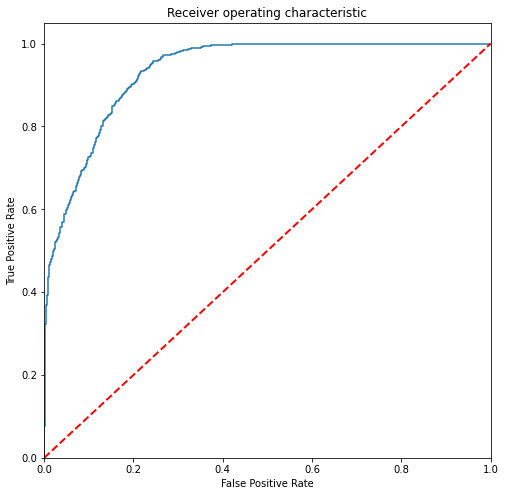

In [309]:
y_score = final_model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, y_score)
plotROCCurve(fpr,tpr)
area = auc(fpr,tpr)
print("AUC:", area)

<font color='darkblue'>We can see from the ROC curve that the RandomForest model shows a higher AUC score after tuning the hyperparameters and it has a good capability to avoid False Positives, but it is better at avioding False Negatives as you can see TPR is constantly equal to 1 after FPR takes over 0.4.

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Looking at the details above GBM might be worthy of further study.
Let us look into the Feature Importance of the GBM model

### Examine the importance of each of the model features. Some models may have a features_importances property. For others you may need to loop over features and exclude/include them to determine their impact on the score.

In [310]:
feature_names = loans_features.columns
n_feats = len(feature_names)

In [311]:
model_list = []
for i in range(len(models)):
    model_list.append((models[i][1]))
rfe_model_list = [model_list[0],model_list[2],model_list[5], model_list[6]] #model list to use RFE method
loop_model_list = [model_list[1],model_list[3],model_list[4]] #model list to loop over

In [312]:
# Print top 5 important features from models which do not have RFE property
for model in loop_model_list:

    print("----------------------------------------------------")    
    print(model.__class__)
    scores_list = []

    for i in range(n_feats):
        X_one_feature = np.array(x_train.iloc[:, i]).reshape(-1,1)
        scores = cross_val_score(model, X_one_feature, Y_train, cv=k_fold)
        scores_mean = scores.mean()
        scores_list.append(scores.mean())

    sorted_indices = np.argsort(np.array(scores_list) * -1) # negate to have descending

    for i in range(0,5): # top 5 features
        index = sorted_indices[i]
        print(i, ":", feature_names[index], scores_list[index])
    
print("----------------------------------------------------")

----------------------------------------------------
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
0 : last_pymnt_amnt 0.80375
1 : term 0.5947727272727272
2 : sub_grade 0.5944318181818182
3 : int_rate 0.5923863636363638
4 : installment 0.551818181818182
----------------------------------------------------
<class 'sklearn.naive_bayes.GaussianNB'>
0 : last_pymnt_amnt 0.7862500000000001
1 : sub_grade 0.6470454545454545
2 : int_rate 0.6464772727272727
3 : term 0.6184090909090909
4 : fico_scores 0.5642045454545455
----------------------------------------------------
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
0 : last_pymnt_amnt 0.7972727272727272
1 : int_rate 0.6476136363636364
2 : sub_grade 0.6475
3 : term 0.6184090909090909
4 : fico_scores 0.565340909090909
----------------------------------------------------


In [313]:
# Print top 5 important features from models which have RFE property
for model in rfe_model_list:
    
    print("-------------------------------------------------")
    
    rfe = RFE(estimator=model, n_features_to_select=5)
    
    print(model.__class__)
    rfe.fit(x_train, Y_train)

    for i in range(0,n_feats):
        if rfe.support_[i] == True:
            print(feature_names[i], end="\n")
    print("")

-------------------------------------------------
<class 'sklearn.linear_model._logistic.LogisticRegression'>
funded_amnt
term
installment
last_pymnt_amnt
sub_grade

-------------------------------------------------
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
installment
last_pymnt_amnt
avg_cur_bal
bc_open_to_buy
mo_sin_old_rev_tl_op

-------------------------------------------------
<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
funded_amnt
int_rate
installment
last_pymnt_amnt
bc_open_to_buy

-------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
int_rate
installment
dti
last_pymnt_amnt
bc_open_to_buy



<font color = 'darkblue'>The most importance features are last_pymnt_amnt, int_rate, term, installment as they appears many times.

### Conclusion

### Write a summary of what you have found.

### Discovery of Feature Scaling
In model implementation part, we not only followed the instructions given to find the best model, but also did the cross validation for the same split dataset without and with feature scaling. We desire to find the fact that what kind of models can be affected a lot by feature scaling. And the outcome turns out as follow:

| Model         |   LR   |   KNN  |    DT   |    NB   |   NN   |   AB    |    RF   |
|:-------------:|:------:|:------:|:-------:|:-------:|:------:|:-------:|:-------:|
|**Differences**|0.039135|0.016275| 0.000000|-0.000096|0.056640|-0.000004| 0.000068|

We can see from the table above that, measuring the AUC score, the performance of Logistic Regression model, KNN model and Neural Networks model have fairly improvement after feature scaling while other models do not have significant change. Therefore, we conclude that it is necessary to do feature scaling when we implement models involving or implicitly using distance calculations to predict.

Without feature scaling, we got the mean of AUC score from 10 folds cross validation:

|  Model        |   LR   |   KNN  |    DT   |    NB   |   NN   |   AB   |    RF   |
|:-------------:|:------:|:------:|:-------:|:-------:|:------:|:------:|:-------:|
| **AUC Score** |0.879412|0.788883|0.796775 |0.897634 |0.849048|0.927759| 0.928534|

With feature scaling, we got the mean of AUC score from 10 folds cross validation:

| Model         |   LR   |   KNN  |    DT   |    NB   |   NN   |   AB   |    RF   |
|:-------------:|:------:|:------:|:-------:|:-------:|:------:|:------:|:-------:|
| **AUC Score** |0.918546|0.805157|0.796775 |0.897538 |0.905689|0.927755| 0.928602|

### Metrics From Random Forest Model
According to AUC scores we got from models above, it is obviously that the **Random Forests model** has the best performance in predicting the probability that a loan will default without or with feature scaling. Then we found the best paramters for **'max_leaf_nodes' = 40 and 'n_estimators' = 300** by using GridSearchCV. The next step is to implement Random Forest model with best parameters to do prediction in testing set.

| Metrics    | Recall | Precision | F1-score | Accuracy |
|:----------:|:------:|:---------:|:--------:|:--------:|
| **Values** |  0.89  |    0.83   |   0.86   |   0.85   |

As we aim to predict the probability of default, we are more concerned about the False Negatives than False Positves. From the table above, our model did a considerably great job in reducing False Negatives with 0.89 recall rate. And other metrics are quite good as well. It is worth mentioning that accuracy could be a reasonable metric for our prediction as the dataset for which we implement the models is balanced. Finally We plot ROC curve and get the AUC score(**0.9347191827765325**).

### Feature Importance
Following the instructions, we then look for the important features. We run recursive feature elimination on Logistic Regression model, Decision Trees model, AdaptBoosting model and Random Forest Model as they have corresponding property. For other models, we loop over features, regress against the targets and determine each feature's explanatory power. We will show the top 5 important features for the different models we used:

| Model       |         LR         |      KNN      |       DT           |       NB      |         
|:-----------:|:------------------:|:-------------:|:------------------:|:-------------:|
|**Feature 1**|funded_amnt         |last_pymnt_amnt|  installment       |last_pymnt_amnt|  
|**Feature 2**|     term           |      term     |last_pymnt_amnt     |   sub_grade   |    
|**Feature 3**|   installment      |   sub_grade   |avg_cur_bal         |    int_rate   |   
|**Feature 4**|last_pymnt_amnt     |    int_rate   |bc_open_to_buy      |      term     |   
|**Feature 5**|   sub_grade        |  installment  |mo_sin_old_rey_tl_op|  fico_scores  |

| Model       |         NN         |       AB      |       RF      |
|:-----------:|:------------------:|:-------------:|:-------------:|
|**Feature 1**|   last_pymnt_amnt  |  funded_amnt  |    int_rate   |
|**Feature 2**|      int_rate      |    int_rate   |  installment  |
|**Feature 3**|       sub_grade    |  installment  |      dti      |
|**Feature 4**|        term        |last_pymnt_amnt|last_pymnt_amnt|
|**Feature 5**| fico_scores        | bc_open_to_buy| bc_open_to_buy|

As we can see above, **'last_pymnt_amnt'** shows in the top 5 important feature list of models above and **'int_rate'** as well as **'installment'** shows in the top 5 important feature list of 5 models. Hence, we would say 'last_pymnt_amnt', 'int_rate' and 'installment' are the most important features to predict the probability of default in this dataset by implementing the models above. It is very reasonbale in reality. If the debtor is able to pay a decent amount of money back as the last payment, he/she is unlikely to default. If interest rate increases, the debtor has to pay more interests. Then the debtor would have more financial pressure so that he/she is more likely to default.